In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torchsummary import summary

In [3]:
# normalising the data, and turning it into a tensor (obviously)

transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# offsets the mean by half, the divides by std. dev.




In [4]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)

classes = list(range(10))

In [7]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images 
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


<Figure size 640x480 with 1 Axes>

    4     2     7     4


In [35]:
print(images.size())

torch.Size([16, 1, 28, 28])


In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(6*26*26, 120) # no padding, image will shrink on edges after conv 
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         print(x.size())
        x = x.view(-1, self.num_flat_features(x))
#         print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to('cuda')

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4056, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [27]:
N_epochs = 5
print_every = 200
for epoch in range(N_epochs):
    print(f'epoch {epoch}')
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = [d.to('cuda') for d in data]
        optimizer.zero_grad() # reset gradient buffers
        output = net(inputs) # run net on input, get output
        loss = criterion(output, labels) # compute loss
        loss.backward() # compute gradient (dweights/dloss)
        optimizer.step() # update weights (using SGD for example)
        
        running_loss += loss.item()
        if i % print_every == print_every - 1:
            print(f'{epoch}, {i}, {running_loss / print_every}')
            running_loss = 0.0
print('done')


epoch 0
0, 199, 0.7651179490238428
0, 399, 0.26384268414229156
0, 599, 0.17389392137527465
0, 799, 0.1381122137606144
epoch 1
1, 199, 0.09153694389387965
1, 399, 0.08596958797425032
1, 599, 0.07576394645497203
1, 799, 0.07600419702008367
epoch 2
2, 199, 0.05106888005509973
2, 399, 0.058225299529731274
2, 599, 0.04764415230602026
2, 799, 0.05307802174240351
epoch 3
3, 199, 0.031511138156056405
3, 399, 0.030702428855001927
3, 599, 0.03753732534125447
3, 799, 0.03789238030090928
epoch 4
4, 199, 0.020477833971381188
4, 399, 0.025647509619593622
4, 599, 0.022448669634759427
4, 799, 0.023817011564970018
done


In [7]:
torch.cuda.is_available()

True

In [8]:
torch.randn(3,3).to('cuda')

tensor([[-0.5701, -0.3253, -0.6578],
        [-0.1640, -0.5507, -0.1456],
        [-0.5413, -0.1629, -0.9822]], device='cuda:0')

In [66]:
PATH = './mnist_net_1.pth'
torch.save(net.state_dict(), PATH)

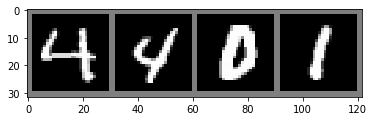

labels: [4, 4, 0, 1]


In [77]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print(f'labels: {list(classes[labels[j]] for j in range(4))}')

In [78]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [79]:
outputs = net(images)
print(outputs)

tensor([[-3.5128, -1.8805,  0.6608, -4.3693, 13.5946, -2.3398, -1.7257,  0.6736,
          0.5256,  1.0267],
        [-3.8483, -0.4576, -3.7708, -7.8454, 18.3886, -1.7589, -1.3990,  2.3793,
         -0.3322,  1.7518],
        [ 9.7792, -2.9378,  1.7730, -4.6323, -1.3177, -2.1759,  0.1541, -2.5081,
          1.4952,  0.5971],
        [-5.9833, 13.1466, -2.1820, -1.9522,  2.0484,  0.7841, -1.6817, -0.7419,
          0.3162, -2.5264]], grad_fn=<AddmmBackward>)


In [94]:
for o in outputs:
    l = [(v, classes[i]) for i,v in enumerate(o)]
    l.sort(reverse=True)
    print(f'{l[0][0]}: {l[0][1]}')
print(labels)
# AYYYYY, now do the whole test set

13.594603538513184: 4
18.388648986816406: 4
9.779165267944336: 0
13.146590232849121: 1
tensor([4, 4, 0, 1])


In [29]:
correct, total = 0, 0
with torch.no_grad(): #REMEMBER TO TURN OFF AUTOGRAD
    for data in testloader:
        images, labels = [d.to('cuda') for d in data]
        outputs = net(images)
        maxval, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'acc: {correct/total}')

acc: 0.9848


In [39]:
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
            Linear-2                  [-1, 120]         486,840
            Linear-3                   [-1, 10]           1,210
Total params: 488,110
Trainable params: 488,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.86
Estimated Total Size (MB): 1.90
----------------------------------------------------------------
